In [1]:
####### dropout resnet18 vs without dropout
#### 
import torch
import sys
sys.path.append("..")
import numpy as np

CLEAN_PATH = "/home/yifan/dataset/resnet18_with_dropout/pairflip/cifar10/0/"
REF_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"


ENCODER_DIMS=[512,256,256,256,256,2]
DECODER_DIMS= [2,256,256,256,256,512]
VIS_MODEL_NAME = 'vis'

DEVICE='cuda:0'
########## initulize reference data and target data
from alignment.data_preprocess import DataInit
REF_EPOCH = 200
TAR_EPOCH = 200
ref_datainit = DataInit(REF_PATH,REF_PATH,REF_EPOCH)
tar_datainit = DataInit(CLEAN_PATH,CLEAN_PATH,TAR_EPOCH)
ref_model, ref_provider, ref_train_data, ref_prediction, ref_prediction_res, ref_scores = ref_datainit.getData()
tar_model, tar_provider, tar_train_data, tar_prediction, tar_prediction_res, tar_scores = tar_datainit.getData()


from alignment.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH,ref_model=ref_model,tar_model=tar_model,DEVICE=DEVICE)

absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates,high_distance_indicates = gen.subsetClassify(18,0.8,0.3,0.05)


from representationTrans.trans_visualizer_border import visualizer
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(TAR_EPOCH),I), projector, 200,[0,1],'tab10')


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 414.30it/s]


NET resnet18_with_dropout
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 6079.79it/s]


absolute alignment indicates number: 106 label diff indicates number: 12 confidence diff indicates number: 16 high distance number: 97


In [2]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(True),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),
            nn.ReLU(True),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [3]:
input_dim = 512
hidden_dim = 512

autoencoder = Autoencoder(input_dim, hidden_dim)


In [4]:
import torch
from torch.utils.data import Dataset

class PairedDataset(Dataset):
    def __init__(self, tensor_X, tensor_Y):
        assert tensor_X.size(0) == tensor_Y.size(0), "X and Y tensors should have the same number of samples"
        self.tensor_X = tensor_X
        self.tensor_Y = tensor_Y

    def __getitem__(self, index):
        return self.tensor_X[index], self.tensor_Y[index]

    def __len__(self):
        return self.tensor_X.size(0)
from torch.utils.data import DataLoader

tensor_X = torch.Tensor(ref_train_data) # Example X tensor with 1000 samples
tensor_Y = torch.Tensor(tar_train_data) # Example Y tensor with 1000 samples

paired_dataset = PairedDataset(tensor_X, tensor_Y)
dataloader = DataLoader(paired_dataset, batch_size=32, shuffle=True)


In [20]:
import torch.optim as optim
import numpy as np
from pyemd import emd
from scipy.spatial.distance import cdist

def earth_movers_distance(X, Y):
    X, Y = X.detach().numpy(), Y.detach().numpy()
    distance_matrix = cdist(X, Y)
    return emd([], [], distance_matrix)

def frobenius_norm_loss(predicted, target):
    return torch.norm(predicted - target, p='fro') / predicted.numel()

# Define hyperparameters
num_epochs = 10
batch_size = 32
learning_rate = 1e-3

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate,weight_decay=1e-5)

alpha = 1 # weight for topological loss, adjust this according to your requirements

# Training loop
for epoch in range(num_epochs):
    for data_X, data_Y in dataloader: # Assuming you have a DataLoader instance with paired data (X, Y)
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass (encoding Y and decoding to X's space)
        transformed_Y = autoencoder.encoder(data_Y)
        recon_X = autoencoder.decoder(transformed_Y)

        # Calculate the loss
        # recon_loss = criterion(recon_X, data_X)

        # topological_loss = earth_movers_distance(data_Y, transformed_Y)

        # loss = recon_loss + alpha * topological_loss
        loss_f_decoder = frobenius_norm_loss(recon_X, data_Y)
        loss_f_encoder = frobenius_norm_loss(transformed_Y, data_X)

        loss = loss_f_decoder + loss_f_encoder

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

    # Print the loss for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Loss decoder: {loss_f_decoder.item():.4f},Loss encoder: {loss_f_encoder.item():.4f}')


Epoch [1/10], Loss: 0.0075, Loss decoder: 0.0023,Loss encoder: 0.0053
Epoch [2/10], Loss: 0.0078, Loss decoder: 0.0024,Loss encoder: 0.0054
Epoch [3/10], Loss: 0.0072, Loss decoder: 0.0024,Loss encoder: 0.0049
Epoch [4/10], Loss: 0.0074, Loss decoder: 0.0022,Loss encoder: 0.0052
Epoch [5/10], Loss: 0.0070, Loss decoder: 0.0023,Loss encoder: 0.0047
Epoch [6/10], Loss: 0.0076, Loss decoder: 0.0023,Loss encoder: 0.0053
Epoch [7/10], Loss: 0.0074, Loss decoder: 0.0023,Loss encoder: 0.0052
Epoch [8/10], Loss: 0.0071, Loss decoder: 0.0022,Loss encoder: 0.0049
Epoch [9/10], Loss: 0.0071, Loss decoder: 0.0022,Loss encoder: 0.0050
Epoch [10/10], Loss: 0.0071, Loss decoder: 0.0022,Loss encoder: 0.0048


In [21]:
# Transform X into Y's space
encoded_X = autoencoder.decoder(tensor_X)

# Transform Y into X's space
encoded_Y = autoencoder.encoder(tensor_Y)

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8728.97it/s]


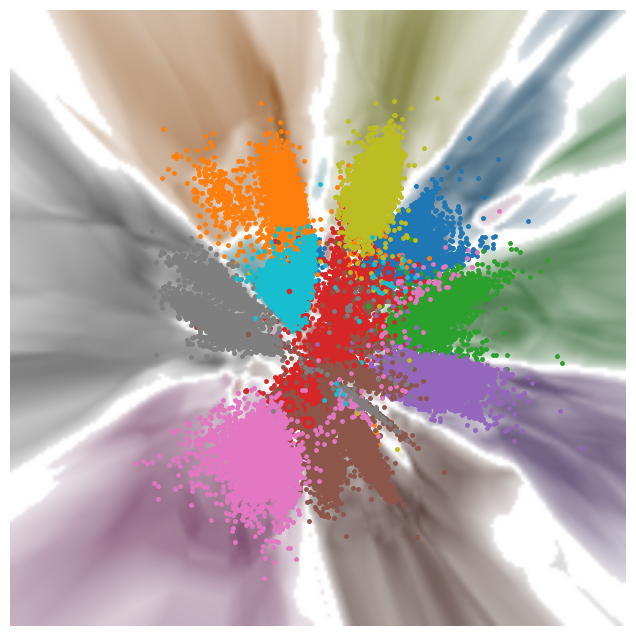

In [15]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(ref_train_data, I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 7436.60it/s]


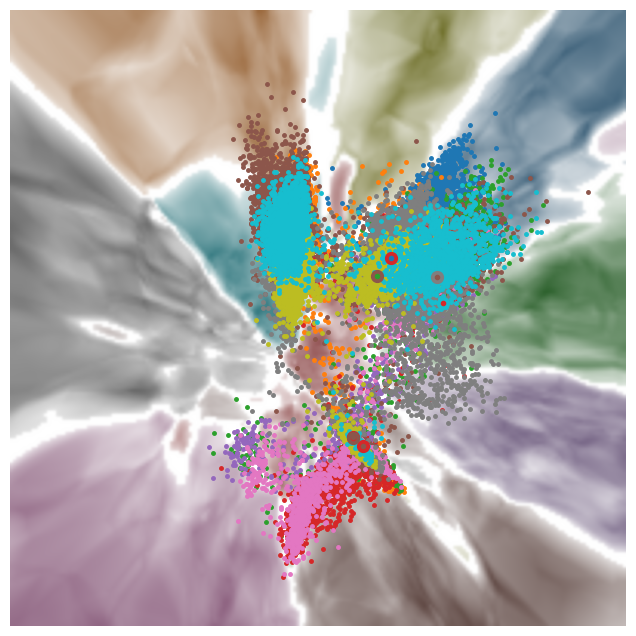

In [23]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(encoded_Y.detach().numpy(), I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8883.60it/s]


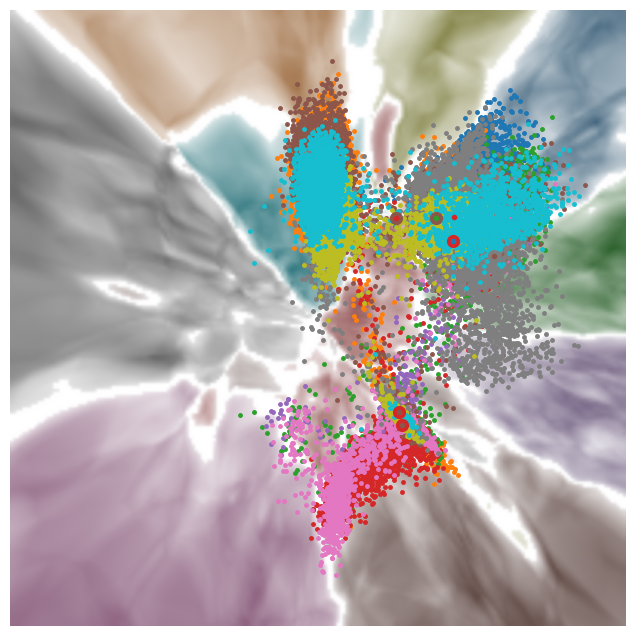

In [18]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(tar_train_data, I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))